In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import librosa
import librosa.display
import IPython
import os
import warnings
import re

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# to prevent fail to get convolution algorithms, set gpu memory growth True
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.experimental.get_memory_growth(physical_devices[0]))

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


All clips are provided as uncompressed PCM 16 bit, 44.1 kHz, mono audio files. All clips used in this competition are released under Creative Commons (CC) licenses, some of them requiring attribution to their original authors and some forbidding further commercial reuse. In order to be able to comply with the CC licenses terms, a full list of audio clips with their associated licenses and a reference to the original content (in Freesound or Flickr) will be published at the end of the competition. Until then, the provided audio files can only be used for the sole purpose of participating in the competition.

## This implementation use only curated 

In [0]:
# Set data path
data_dir = '/home/han/stt_dataset/freesound-audio-tagging-2019'

In [0]:
train_curated = pd.read_csv(data_dir + '/train_curated.csv')

In [5]:
train_curated.sample(5)

,fname,labels
1571,5195d220.wav,Burping_and_eructation
4481,e7995482.wav,Bark
1765,5bde3e22.wav,Shatter
3585,b955bc8e.wav,Scissors
1411,499c95f6.wav,Finger_snapping


In [6]:
# Check the sound 2767
display(train_curated.iloc[2767, :])

test_sound_file = train_curated.iloc[2767, 0]

IPython.display.Audio(data_dir + '/train_curated' + '/' + test_sound_file)

fname      8ed29f42.wav
labels    Raindrop,Drip
Name: 2767, dtype: object

In [0]:
# requires to split the label

def true_labels_split(x):
  result = x.split(',')
  return result[0]

def labels_explaner(x):
  result = x.split(',')
  if len(result) == 1:
    return ''
  else:
    return result[-1]

In [8]:
train_curated.iloc[2764:2768, :]

,fname,labels
2764,8ebeb89c.wav,Gong
2765,8ebf9f33.wav,"Raindrop,Bathtub_(filling_or_washing)"
2766,8ec9e8b0.wav,Shatter
2767,8ed29f42.wav,"Raindrop,Drip"


In [9]:
train_curated.loc[2764:2768, 'labels'].apply(true_labels_split)

2764           Gong
2765       Raindrop
2766        Shatter
2767       Raindrop
2768    Church_bell
Name: labels, dtype: object

In [10]:
train_curated.loc[2764:2768, 'labels'].apply(labels_explaner)

2764                                
2765    Bathtub_(filling_or_washing)
2766                                
2767                            Drip
2768                                
Name: labels, dtype: object

In [0]:
train_curated['True_label'] = train_curated['labels'].apply(true_labels_split)
train_curated['label_additional'] = train_curated['labels'].apply(labels_explaner)

In [12]:
train_curated.head()

,fname,labels,True_label,label_additional
0,0006ae4e.wav,Bark,Bark,
1,0019ef41.wav,Raindrop,Raindrop,
2,001ec0ad.wav,Finger_snapping,Finger_snapping,
3,0026c7cb.wav,Run,Run,
4,0026f116.wav,Finger_snapping,Finger_snapping,


In [0]:
train_curated = train_curated.loc[:, ['fname', 'True_label', 'label_additional']]

In [14]:
train_curated.True_label.unique()

array(['Bark', 'Raindrop', 'Finger_snapping', 'Run', 'Whispering',
       'Acoustic_guitar', 'Hi-hat', 'Bass_drum', 'Crowd', 'Frying_(food)',
       'Chewing_and_mastication', 'Fart', 'Bass_guitar', 'Knock',
       'Motorcycle', 'Stream', 'Male_singing', 'Crackle', 'Sigh',
       'Burping_and_eructation', 'Female_singing', 'Tap',
       'Female_speech_and_woman_speaking',
       'Accelerating_and_revving_and_vroom', 'Cheering', 'Accordion',
       'Zipper_(clothing)', 'Bus', 'Meow', 'Waves_and_surf',
       'Microwave_oven', 'Child_speech_and_kid_speaking', 'Buzz',
       'Car_passing_by', 'Toilet_flush', 'Purr', 'Church_bell',
       'Electric_guitar', 'Marimba_and_xylophone', 'Trickle_and_dribble',
       'Harmonica', 'Male_speech_and_man_speaking', 'Slam',
       'Keys_jangling', 'Sink_(filling_or_washing)',
       'Traffic_noise_and_roadway_noise', 'Squeak', 'Cricket',
       'Fill_(with_liquid)', 'Skateboard', 'Shatter',
       'Drawer_open_or_close', 'Race_car_and_auto_racing',
 

In [15]:
train_curated.head()

,fname,True_label,label_additional
0,0006ae4e.wav,Bark,
1,0019ef41.wav,Raindrop,
2,001ec0ad.wav,Finger_snapping,
3,0026c7cb.wav,Run,
4,0026f116.wav,Finger_snapping,


In [0]:
label_ohe = pd.get_dummies(train_curated['True_label'])

In [17]:
label_ohe.head()

,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,...,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# Get original data
sample_submission = pd.read_csv('stt_dataset/freesound-audio-tagging-2019/sample_submission.csv')
label_col = sample_submission.columns.tolist()[1:]

### Define load and preprocess dataset

In [0]:
class conf:
  '''
  The hyperparams from 
    daisukelab
  '''
  sampling_rate = 44100
  duration = 2 # sec
  hop_length = 347*duration # to make time steps 128
  fmin = 20
  fmax = sampling_rate // 2
  n_mels = 128
  n_fft = n_mels * 20
  padmode = 'constant'
  samples = sampling_rate * duration

audio_config = conf()

### Define Preprocessing Function

In [0]:
# load audio file

test_file = 'stt_dataset/freesound-audio-tagging-2019/train_curated/0006ae4e.wav'
# load audio file

# test_file = 'stt_dataset/freesound-audio-tagging-2019/train_curated/0006ae4e.wav'


y, sr = librosa.load(test_file, sr=44100)

# trim silence
y, trim_point = librosa.effects.trim(y)
# requires to pad 
# if the length of the loaded data is shorther than the sample, padd it
if len(y) >= audio_config.samples:  # ex: len(y) = 900000, audio_config.samples = 44100 * 2 == 88200
  y = y[0:0+audio_config.samples]   # y = y[0 : 0 + 88200]

else:
  # padding blank                          # len(y) = 70000
  padding = audio_config.samples - len(y)  # padding = audio_config.samples == 88200  - 70000 == 18200
  offset = padding // 2                    # offset = 18200 // 2 == 9100
  
  y= np.pad(y, 
            pad_width=(offset, audio_config.samples - len(y) - offset),
            mode='constant')   # y = (70000,)
                                # pad_width = (6100, 88200 - 70000 - 9100 == 18200 - 9100 = 9100)
# get log_specgrogram
mel_spectrogram = librosa.feature.melspectrogram(y, 
                                                sr=44100, 
                                                n_fft=audio_config.n_fft, 
                                                hop_length=audio_config.hop_length,
                                                window='hann', 
                                                n_mels=audio_config.n_mels,
                                                fmin=audio_config.fmin,
                                                fmax=audio_config.fmax)

spectrogram = librosa.power_to_db(mel_spectrogram)
spectrogram = spectrogram.reshape(128, 128)

In [0]:
# load audio file

# test_file = 'stt_dataset/freesound-audio-tagging-2019/train_curated/0006ae4e.wav'
def get_spectrogram(test_file):

  y, sr = librosa.load(test_file, sr=44100)

  # trim silence
  y, trim_point = librosa.effects.trim(y)
  # requires to pad 
  # if the length of the loaded data is shorther than the sample, padd it
  if len(y) >= audio_config.samples:  # ex: len(y) = 900000, audio_config.samples = 44100 * 2 == 88200
    y = y[0:0+audio_config.samples]   # y = y[0 : 0 + 88200]

  else:
    # padding blank                          # len(y) = 70000
    padding = audio_config.samples - len(y)  # padding = audio_config.samples == 88200  - 70000 == 18200
    offset = padding // 2                    # offset = 18200 // 2 == 9100
    
    y= np.pad(y, 
              pad_width=(offset, audio_config.samples - len(y) - offset),
              mode='constant')   # y = (70000,)
                                 # pad_width = (6100, 88200 - 70000 - 9100 == 18200 - 9100 = 9100)
  # get log_specgrogram
  mel_spectrogram = librosa.feature.melspectrogram(y, 
                                                  sr=44100, 
                                                  n_fft=audio_config.n_fft, 
                                                  hop_length=audio_config.hop_length,
                                                  window='hann', 
                                                  n_mels=audio_config.n_mels,
                                                  fmin=audio_config.fmin,
                                                  fmax=audio_config.fmax)
  
  spectrogram = librosa.power_to_db(mel_spectrogram)
  spectrogram = spectrogram.reshape(128, 128)

  return spectrogram.astype('float')

In [22]:
test_result = get_spectrogram(test_file)

test_result.shape

(128, 128)

In [23]:
train_curated.head()

,fname,True_label,label_additional
0,0006ae4e.wav,Bark,
1,0019ef41.wav,Raindrop,
2,001ec0ad.wav,Finger_snapping,
3,0026c7cb.wav,Run,
4,0026f116.wav,Finger_snapping,


In [0]:
le = LabelEncoder()
train_curated['True_label_encode'] = le.fit_transform(train_curated['True_label'])

In [25]:
train_curated.head()

,fname,True_label,label_additional,True_label_encode
0,0006ae4e.wav,Bark,,4
1,0019ef41.wav,Raindrop,,55
2,001ec0ad.wav,Finger_snapping,,34
3,0026c7cb.wav,Run,,56
4,0026f116.wav,Finger_snapping,,34


In [0]:
# Create Tensorflow dataset

# 1) convert the with absolute file path
#   ex) 'stt_dataset/freesound-audio-tagging-2019/train_curated/0006ae4e.wav'
def abs_file_path(x):
  return os.path.join(data_dir, 'train_curated', x)


train_curated['abs_file_path'] = train_curated['fname'].apply(abs_file_path)



file_path = train_curated['abs_file_path'].tolist()

In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_curated['abs_file_path'],
                                                    train_curated['True_label'],
                                                    test_size=0.2,
                                                    stratify=train_curated['True_label'],
                                                    random_state=1228)

In [28]:
print(x_train.shape)
print(y_train.shape)

print('---')
print(x_test.shape)
print(y_test.shape)

(3976,)
(3976,)
---
(994,)
(994,)


In [29]:
x_train

3047    /home/han/stt_dataset/freesound-audio-tagging-...
2376    /home/han/stt_dataset/freesound-audio-tagging-...
1921    /home/han/stt_dataset/freesound-audio-tagging-...
3480    /home/han/stt_dataset/freesound-audio-tagging-...
3266    /home/han/stt_dataset/freesound-audio-tagging-...
                              ...                        
2737    /home/han/stt_dataset/freesound-audio-tagging-...
3466    /home/han/stt_dataset/freesound-audio-tagging-...
4499    /home/han/stt_dataset/freesound-audio-tagging-...
4308    /home/han/stt_dataset/freesound-audio-tagging-...
3501    /home/han/stt_dataset/freesound-audio-tagging-...
Name: abs_file_path, Length: 3976, dtype: object

In [0]:
y_train = pd.get_dummies(y_train, columns=label_col)
y_test = pd.get_dummies(y_test, columns=label_col)

In [31]:
y_train.head()

,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,...,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
3047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
audio_config.samples

88200

In [0]:
# dataset

def get_spectrogram(test_file):

  test_file = test_file.numpy() # for the tensorflow dataset format
  y, sr = librosa.load(test_file, sr=44100)

  # trim silence
  y, trim_point = librosa.effects.trim(y)
  # requires to pad 
  # if the length of the loaded data is shorther than the sample, padd it
  if len(y) >= audio_config.samples:  # ex: len(y) = 900000, audio_config.samples = 44100 * 2 == 88200
    y = y[0:0+audio_config.samples]   # y = y[0 : 0 + 88200]

  else:
    # padding blank                          # len(y) = 70000
    padding = audio_config.samples - len(y)  # padding = audio_config.samples == 88200  - 70000 == 18200
    offset = padding // 2                    # offset = 18200 // 2 == 9100
    
    y= np.pad(y, 
              pad_width=(offset, audio_config.samples - len(y) - offset),
              mode='constant')   # y = (70000,)
                                 # pad_width = (6100, 88200 - 70000 - 9100 == 18200 - 9100 = 9100)
  # get log_specgrogram
  mel_spectrogram = librosa.feature.melspectrogram(y, 
                                                  sr=44100, 
                                                  n_fft=audio_config.n_fft, 
                                                  hop_length=audio_config.hop_length,
                                                  window='hann', 
                                                  n_mels=audio_config.n_mels,
                                                  fmin=audio_config.fmin,
                                                  fmax=audio_config.fmax)
  
  spectrogram = librosa.power_to_db(mel_spectrogram)
  spectrogram = spectrogram.reshape(128, 128)

  return spectrogram.astype('float')

#### Requires to Check 

***numpy pad***

In [0]:
def create_dataset(x, y, is_train=True):
  # x
  train_data_set = tf.data.Dataset.from_tensor_slices(x.values.tolist())
  train_data_set = train_data_set.map(lambda x: tf.py_function(get_spectrogram, [x], tf.float32))
  train_data_set = train_data_set.padded_batch(1, padded_shapes=[128,128])
  train_data_set = train_data_set.unbatch()
  # y
  train_data_label = tf.data.Dataset.from_tensor_slices(y.values.astype(np.float32))
  # zip
  train_data = tf.data.Dataset.zip((train_data_set, train_data_label))

  # if is_train:
    # train_data = train_data.shuffle(4000)
  train_data = train_data.batch(32)
  train_data = train_data.prefetch(16)
  return train_data

In [0]:
train_data_set = create_dataset(x_train, y_train, is_train=True)
test_data_set = create_dataset(x_test, y_test, is_train=False)

In [82]:
train_data_set

<PrefetchDataset shapes: ((None, 128, 128), (None, 78)), types: (tf.float32, tf.float32)>

In [0]:
# for n, i in enumerate(train_data_set):
#   print(i)
#   if n == 0:
#     break

In [0]:
# checking data
# (x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data()
# tf.keras.utils.to_categorical(y_mnist_train).shape

## Define Classifier Model

In [0]:
# input shape = 128, 128

class Residual_Block(keras.layers.Layer):
  def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
    super(Residual_Block, self).__init__(**kwargs)
    self.filters = filters
    self.kernel_size = kernel_size
    self.dilation_rate = dilation_rate
    self.conv1 = keras.layers.Conv1D(filters=self.filters,
                                     kernel_size=self.kernel_size,
                                     use_bias=False, 
                                     padding='causal',
                                     dilation_rate=self.dilation_rate)
    self.conv2 = keras.layers.Conv1D(filters=self.filters,
                                     kernel_size=self.kernel_size,
                                     use_bias=False, 
                                     padding='causal',
                                     dilation_rate=self.dilation_rate)
    self.add = keras.layers.Add()
    self.bn1 = keras.layers.BatchNormalization()
    self.dr1 = keras.layers.Dropout(0.3)
    self.bn2 = keras.layers.BatchNormalization()
    self.dr2 = keras.layers.Dropout(0.3)

  def call(self, x):
    
    z = self.conv1(x)
    z = tf.nn.leaky_relu(z)
    z = self.bn1(z)
    # z = self.dr1(z)

    z = self.conv2(z)
    z = tf.nn.leaky_relu(z)
    z = self.bn2(z)
    # z = self.dr2(z)

    z = self.add([x, z])
    return z

In [0]:
checking_input = keras.layers.Input(shape=(128,128))
x = keras.layers.Conv1D(512, 7, 1, padding='causal', activation='relu')(checking_input)
x = Residual_Block(512, 4, 1)(x)

check_model = keras.models.Model(checking_input, x)

In [41]:
x

<tf.Tensor 'residual__block/Identity:0' shape=(None, 128, 512) dtype=float32>

In [42]:
check_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 512)          459264    
_________________________________________________________________
residual__block (Residual_Bl (None, 128, 512)          2101248   
Total params: 2,560,512
Trainable params: 2,558,464
Non-trainable params: 2,048
_________________________________________________________________


## Residual Connection Model

In [0]:
def model(units):
  input_ = keras.layers.Input(shape=(128,128))
  base_conv = keras.layers.LayerNormalization()(input_)
  base_conv = keras.layers.Conv1D(units, 4, strides=1, padding='causal', use_bias=False)(base_conv)
  base_conv = keras.layers.LeakyReLU()(base_conv)
  base_conv = keras.layers.Conv1D(units, 4, strides=1, padding='causal', use_bias=False)(base_conv)
  base_conv = keras.layers.LeakyReLU()(base_conv)
  base_conv = keras.layers.Conv1D(units, 4, strides=1, padding='causal', use_bias=False)(base_conv)
  base_conv = keras.layers.LeakyReLU()(base_conv)

  x = base_conv
  for n, rate in enumerate((1,2,4,8) * 2):
    x = Residual_Block(units, 4, rate, name=f'n{n}_b0_r{rate}')(x)
    x = Residual_Block(units, 4, rate, name=f'n{n}_b1_r{rate}')(x)
    x = Residual_Block(units, 4, rate, name=f'n{n}_b2_r{rate}')(x)
  c = keras.layers.Conv1D(units, 4, padding='causal', dilation_rate=1, use_bias=False)(x)
  c = keras.layers.BatchNormalization()(c)
  # c = keras.layers.Dropout(0.4)(c)
  g_m = keras.layers.GlobalMaxPool1D()(c)
  g_a = keras.layers.GlobalAvgPool1D()(c)
  merge = keras.layers.Concatenate()([g_m, g_a])
  fc = keras.layers.Dense(units, use_bias=False)(merge)
  fc = keras.layers.LeakyReLU()(fc)
  fc = keras.layers.Dense(units, use_bias=False)(fc)
  fc = keras.layers.LeakyReLU()(fc)
  fc = keras.layers.Dense(units, use_bias=False)(fc)
  fc = keras.layers.LeakyReLU()(fc)
  out_ = keras.layers.Dense(78, activation='softmax')(fc)

  return keras.models.Model(input_, out_)

In [0]:
model_1 = model(128)

In [45]:
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128)]   0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 128, 128)     256         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 128, 128)     65536       layer_normalization[0][0]        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128)     0           conv1d_3[0][0]                   
____________________________________________________________________________________________

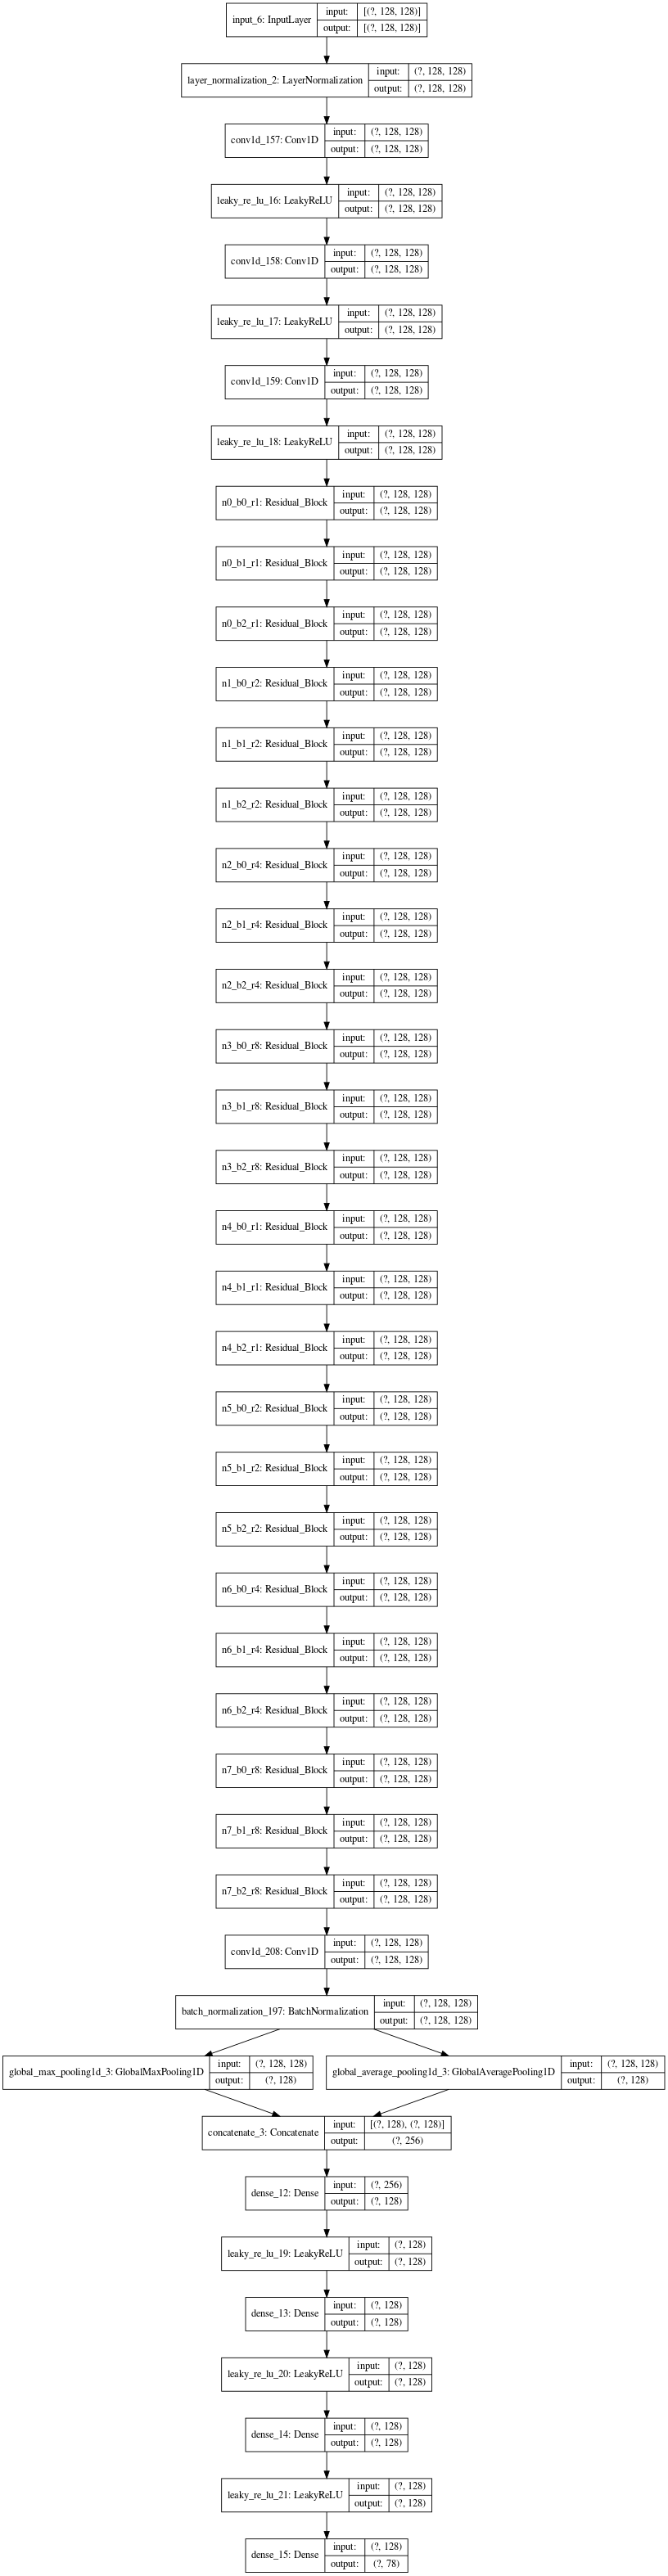

In [70]:
keras.utils.plot_model(model_1, show_shapes=True, dpi=64)

## Brief check the Data Pipe line

In [0]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# training warmup
hist = model_1.fit(train_data_set, epochs=50, validation_data=test_data_set)

Epoch 1/50
125/125 [==============================] - 105s 839ms/step - loss: 4.1443 - acc: 0.0521 - val_loss: 11.5936 - val_acc: 0.0463
Epoch 2/50
125/125 [==============================] - 96s 765ms/step - loss: 3.8526 - acc: 0.0958 - val_loss: 6.4670 - val_acc: 0.0835
Epoch 3/50
125/125 [==============================] - 96s 766ms/step - loss: 3.6958 - acc: 0.1122 - val_loss: 5.0700 - val_acc: 0.0895
Epoch 4/50
125/125 [==============================] - 94s 748ms/step - loss: 3.5697 - acc: 0.1318 - val_loss: 4.5297 - val_acc: 0.1006
Epoch 5/50
125/125 [==============================] - 94s 754ms/step - loss: 3.4455 - acc: 0.1554 - val_loss: 4.0745 - val_acc: 0.1278
Epoch 6/50
125/125 [==============================] - 98s 786ms/step - loss: 3.3209 - acc: 0.1703 - val_loss: 3.8948 - val_acc: 0.1328
Epoch 7/50
125/125 [==============================] - 93s 741ms/step - loss: 3.2042 - acc: 0.1886 - val_loss: 3.6532 - val_acc: 0.1630
Epoch 8/50
125/125 [==============================] -

In [0]:
models = model(128)

In [83]:
train_data_set

<PrefetchDataset shapes: ((None, 128, 128), (None, 78)), types: (tf.float32, tf.float32)>

In [84]:
test_data_set

<PrefetchDataset shapes: ((None, 128, 128), (None, 78)), types: (tf.float32, tf.float32)>

In [97]:
# Create Custom Training Loop

# Created Data-set (tf data)
#   train_data_set
#   validation_data=test_data_set
# --------------------------------------------------------------------------- #


# loss
loss_function = tf.keras.losses.CategoricalCrossentropy()

# optimzier
model_optimizer = tf.keras.optimizers.Adam()

# monitor metrics
train_loss = tf.keras.metrics.Mean()  # metrics mean for the train loss
train_acc = tf.keras.metrics.CategoricalAccuracy()    # metrics mean for train acc

val_loss = tf.keras.metrics.Mean()    # metrics mean for the val loss
val_acc = tf.keras.metrics.CategoricalAccuracy()      # metrics mean for val acc 



# define train step
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_pred = models(x, training=True)
    loss_value = loss_function(y, y_pred)

  model_g = tape.gradient(loss_value, models.trainable_variables)
  train_loss_mean = train_loss(loss_value)
  train_acc_mean = train_acc(y, y_pred)
  model_optimizer.apply_gradients(zip(model_g, models.trainable_variables))


# define val step
@tf.function
def val_step(x, y):
  with tf.GradientTape() as val_tape:
    y_pred = models(x, training=True)
    val_loss_value = loss_function(y, y_pred)
  val_g = val_tape.gradient(val_loss_value, models.trainable_variables)

  val_loss(val_loss_value)
  val_acc(y, y_pred)



# training loop
EPOCHS = 50
for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_acc.reset_states()
  val_loss.reset_states()
  val_acc.reset_states()

  for x1, y1 in train_data_set:
    train_step(x1, y1)
  
  # 02.21 / 11:31 - remove for debug
  # found the errro casuation:??
  # Rewrite the tf.function for val_step
  for x2, y2 in test_data_set:
    val_step(x2, y2)

  temp = 'Epoch {}\tTrain Loss {}\t Train Acc {}\t Val Loss {}\t Val Acc {}'
  print(temp.format(epoch, train_loss.result(), train_acc.result()*100, val_loss.result(), val_acc.result()*100))

Epoch 0	Train Loss 3.245745897293091	 Train Acc 18.234405517578125	 Val Loss 3.490176200866699	 Val Acc 16.19718360900879
Epoch 1	Train Loss 3.107450485229492	 Train Acc 21.32796859741211	 Val Loss 3.457136869430542	 Val Acc 17.102615356445312
Epoch 2	Train Loss 2.9951422214508057	 Train Acc 23.692153930664062	 Val Loss 3.4272983074188232	 Val Acc 18.611669540405273
Epoch 3	Train Loss 2.881686210632324	 Train Acc 25.829978942871094	 Val Loss 3.4264838695526123	 Val Acc 18.108652114868164


KeyboardInterrupt: ignored